# Task 4: MaxPool2d to Strided Convolution Ablation

## 4.1 Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import wandb

# Import from src package
from src import (
    EarlyFusion,
    LateFusion,
    IntermediateFusion,
    FusionDataset,
    seed_everything,
    seed_worker,
    train_model
)
from torch.utils.data import DataLoader

# Set seed for reproducibility
SEED = 42
seed_everything(SEED)
print(f"Set random seed to {SEED} for reproducibility")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# Login to W&B
wandb.login()

Set random seed to 42 for reproducibility
Using device: cuda
GPU: NVIDIA A100-PCIE-40GB
Available GPU memory: 39.49 GB


wandb: Currently logged in as: josefpribbernow (josefpribbernow-hasso-plattner-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 4.2 Dataset Configuration

Using FusionDataset from src package with same configuration as Task 3.

In [2]:
# Configuration
BATCH_SIZE = 32
SUBSET_SIZE = 1000  # Use 1000 samples per class for faster experimentation
VALID_BATCHES = 10

valid_N = VALID_BATCHES * BATCH_SIZE
train_N = SUBSET_SIZE - valid_N

print(f"Dataset Configuration:")
print(f"  Subset size per class: {SUBSET_SIZE}")
print(f"  Train samples per class: {train_N}")
print(f"  Validation samples per class: {valid_N}")
print(f"  Total train samples: {train_N * 2}")
print(f"  Total validation samples: {valid_N * 2}")

# Create datasets using src package
train_data = FusionDataset("data/assessment/", 0, train_N, device=device)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, 
                              drop_last=True, worker_init_fn=seed_worker)
valid_data = FusionDataset("data/assessment/", train_N, SUBSET_SIZE, device=device)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, 
                              drop_last=True, worker_init_fn=seed_worker)

Dataset Configuration:
  Subset size per class: 1000
  Train samples per class: 680
  Validation samples per class: 320
  Total train samples: 1360
  Total validation samples: 640


## 4.3 Model Architectures

Using LateFusion models from src package with different embedder types (MaxPool vs Strided).

## 4.4 Run Ablation Experiments

Train both architectures using train_ablation_model from src package with identical hyperparameters.

## 4.5 Run Ablation Experiments

Architectures to test:
  1. Early Fusion
  2. Late Fusion
  3. Intermediate Fusion (Concatenation)
  4. Intermediate Fusion (Addition)
  5. Intermediate Fusion (Hadamard)

Total experiments: 10 (5 architectures × 2 pooling types)

In [3]:
ablation_results = []

# Training hyperparameters
EPOCHS = 20
LEARNING_RATE = 0.001

In [4]:
# Define all architectures to test
architectures = [
    {"name": "Early Fusion", "class": EarlyFusion, "kwargs": {}},
    {"name": "Late Fusion", "class": LateFusion, "kwargs": {}},
    {"name": "Intermediate Fusion (Concat)", "class": IntermediateFusion, "kwargs": {"merge_method": "concat"}},
    {"name": "Intermediate Fusion (Add)", "class": IntermediateFusion, "kwargs": {"merge_method": "add"}},
    {"name": "Intermediate Fusion (Hadamard)", "class": IntermediateFusion, "kwargs": {"merge_method": "hadamard"}},
]

pooling_types = [
    {"name": "MaxPool2d", "use_strided": False},
    {"name": "Strided Conv", "use_strided": True}
]

# Run all experiments
experiment_num = 0
for arch in architectures:
    for pool in pooling_types:
        experiment_num += 1
        
        print("\n" + "="*80)
        print(f"EXPERIMENT {experiment_num}/10: {arch['name']} with {pool['name']}")
        print("="*80)
        
        # Create model
        model_kwargs = {**arch["kwargs"], "use_strided": pool["use_strided"]}
        model = arch["class"](**model_kwargs).to(device)
        
        # Create model name for W&B
        arch_short = arch["name"].replace(" ", "_").replace("(", "").replace(")", "")
        pool_short = "Strided" if pool["use_strided"] else "MaxPool"
        model_name = f"03_{arch_short}_{pool_short}"
        
        # Train model using unified train_model function
        results = train_model(
            model=model,
            model_name=model_name,
            train_dataloader=train_dataloader,
            valid_dataloader=valid_dataloader,
            train_N=train_N,
            valid_N=valid_N,
            subset_size=SUBSET_SIZE,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            lr=LEARNING_RATE,
            seed=SEED,
            task_type="ablation",
            architecture_type=arch["name"],
            pooling_type=pool["name"]
        )
        
        ablation_results.append(results)
        
        # Clear GPU memory
        del model
        torch.cuda.empty_cache()

print("\n" + "="*80)
print("ALL ABLATION EXPERIMENTS COMPLETED!")
print(f"Total experiments run: {len(ablation_results)}")
print("="*80)


EXPERIMENT 1/10: Early Fusion with MaxPool2d



Training 03_Early_Fusion_MaxPool
Architecture: Early Fusion
Pooling: MaxPool2d
Epoch 1/20 | Train Loss: 0.6956 Acc: 0.4777 | Val Loss: 0.6933 Acc: 0.5000 F1: 0.0000 | Time: 1.06s
Epoch 5/20 | Train Loss: 0.6933 Acc: 0.5030 | Val Loss: 0.6933 Acc: 0.5000 F1: 0.6667 | Time: 0.36s
Epoch 10/20 | Train Loss: 0.6933 Acc: 0.4859 | Val Loss: 0.6930 Acc: 0.5000 F1: 0.6667 | Time: 0.36s
Epoch 15/20 | Train Loss: 0.3017 Acc: 0.8996 | Val Loss: 0.2760 Acc: 0.9109 F1: 0.9079 | Time: 0.36s
Epoch 20/20 | Train Loss: 0.0653 Acc: 0.9911 | Val Loss: 0.0516 Acc: 0.9938 F1: 0.9938 | Time: 0.36s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▁▁▁▁▁▃▁▃▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▁▁▁▁▁▁▁▁▁▂▅▅▆▇▇▇███
train/f1,▃▄▅▃▂▃▃▅▂▁▄▆▆▇▇▇▇███
train/loss,███████████▆▆▅▄▃▂▂▂▁
valid/accuracy,▁▁▁▁▁▁▁▁▁▁▄▅▅▆▇███▇█
valid/f1,▁▆▁▁▆▆▁▆▁▆▆▇▇▇▇█████
valid/loss,██████████▇▆▆▄▃▂▂▁▂▁
avg_epoch_time,0.42036
best_val_accuracy,0.99375



EXPERIMENT 2/10: Early Fusion with Strided Conv



Training 03_Early_Fusion_Strided
Architecture: Early Fusion
Pooling: Strided Conv
Epoch 1/20 | Train Loss: 0.6954 Acc: 0.4829 | Val Loss: 0.6933 Acc: 0.5000 F1: 0.0000 | Time: 0.25s
Epoch 5/20 | Train Loss: 0.6933 Acc: 0.5015 | Val Loss: 0.6933 Acc: 0.5000 F1: 0.6667 | Time: 0.23s
Epoch 10/20 | Train Loss: 0.6933 Acc: 0.4777 | Val Loss: 0.6931 Acc: 0.5000 F1: 0.6667 | Time: 0.22s
Epoch 15/20 | Train Loss: 0.6943 Acc: 0.4874 | Val Loss: 0.6933 Acc: 0.5000 F1: 0.6667 | Time: 0.22s
Epoch 20/20 | Train Loss: 0.6956 Acc: 0.4621 | Val Loss: 0.6934 Acc: 0.5000 F1: 0.6667 | Time: 0.22s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▃▁▂▄▂▂▂▂▂▁▄▃▂▂▁▂▆▆▁
train/accuracy,▅▅▇▅█▅▆▇▃▄▄█▆▇▅▄▂██▁
train/f1,▅▇█▇▅▆▆█▅▃▄▆▅▇▅▇▆▁█▄
train/loss,▇▃▁▃▁▂▃▂▂▁▂▁▂▂▄▃▂▂▁█
valid/accuracy,████████████▁███████
valid/f1,▁█▁▁██▁█▁█▁█▃▁██▁███
valid/loss,▃▁▁█▂▃▁▁▁▁▁▁▁▂▃▂▂▁▁▃
avg_epoch_time,0.2242
best_val_accuracy,0.47969



EXPERIMENT 3/10: Late Fusion with MaxPool2d



Training 03_Late_Fusion_MaxPool
Architecture: Late Fusion
Pooling: MaxPool2d
Epoch 1/20 | Train Loss: 0.6945 Acc: 0.4993 | Val Loss: 0.6928 Acc: 0.5000 F1: 0.0000 | Time: 0.58s
Epoch 5/20 | Train Loss: 0.3333 Acc: 0.8683 | Val Loss: 0.2989 Acc: 0.8859 F1: 0.8965 | Time: 0.56s
Epoch 10/20 | Train Loss: 0.1100 Acc: 0.9688 | Val Loss: 0.2187 Acc: 0.9281 F1: 0.9329 | Time: 0.62s
Epoch 15/20 | Train Loss: 0.0453 Acc: 0.9888 | Val Loss: 0.0732 Acc: 0.9828 F1: 0.9831 | Time: 0.29s
Epoch 20/20 | Train Loss: 0.0597 Acc: 0.9851 | Val Loss: 0.2678 Acc: 0.9203 F1: 0.9262 | Time: 0.29s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,▅▅▅▄▄▄▄▄▄▅▄█▅▃▁▁▁▁▁▁
train/accuracy,▁▃▅▆▆▇▇▇████████████
train/f1,▁▅▆▆▇▇▇█████████████
train/loss,██▆▅▄▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁
valid/accuracy,▁▂▅▆▇▇▇▇█▇▇████████▇
valid/f1,▁▄▇▇▇▇██████████████
valid/loss,██▆▄▃▃▃▂▂▃▂▂▁▁▁▁▂▁▁▃
avg_epoch_time,0.49639
best_val_accuracy,0.98281



EXPERIMENT 4/10: Late Fusion with Strided Conv



Training 03_Late_Fusion_Strided
Architecture: Late Fusion
Pooling: Strided Conv
Epoch 1/20 | Train Loss: 0.6950 Acc: 0.4948 | Val Loss: 0.6934 Acc: 0.5000 F1: 0.0000 | Time: 0.25s
Epoch 5/20 | Train Loss: 0.5448 Acc: 0.7493 | Val Loss: 0.5509 Acc: 0.7203 F1: 0.7804 | Time: 0.22s
Epoch 10/20 | Train Loss: 0.3937 Acc: 0.8385 | Val Loss: 0.4031 Acc: 0.8266 F1: 0.8465 | Time: 0.22s
Epoch 15/20 | Train Loss: 0.2659 Acc: 0.8973 | Val Loss: 0.2965 Acc: 0.8828 F1: 0.8911 | Time: 0.22s
Epoch 20/20 | Train Loss: 0.1775 Acc: 0.9375 | Val Loss: 0.2182 Acc: 0.9234 F1: 0.9259 | Time: 0.22s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▂▁▁▁▃▃▂▁▁▂▃▁▁▁▂▂▁▁▂
train/accuracy,▁▁▁▂▅▅▆▆▆▆▇▇▆▇▇█▇▇██
train/f1,▁▃▄▄▆▆▆▇▇▇▇▇▆▇███▇██
train/loss,████▆▅▅▅▅▄▄▃▄▃▂▂▂▂▂▁
valid/accuracy,▁▁▁▅▅▅▅▆▆▆▅▇▇▇▇██▇▇█
valid/f1,▁▆▁▇▇▇▇▇▇▇▇█████████
valid/loss,███▇▆▅▅▅▅▄▆▃▃▃▂▂▂▂▂▁
avg_epoch_time,0.22199
best_val_accuracy,0.92344



EXPERIMENT 5/10: Intermediate Fusion (Concat) with MaxPool2d



Training 03_Intermediate_Fusion_Concat_MaxPool
Architecture: Intermediate Fusion (Concat)
Pooling: MaxPool2d
Epoch 1/20 | Train Loss: 0.8014 Acc: 0.4985 | Val Loss: 0.6932 Acc: 0.5000 F1: 0.6667 | Time: 0.27s
Epoch 5/20 | Train Loss: 0.4561 Acc: 0.7805 | Val Loss: 0.4526 Acc: 0.7906 F1: 0.8218 | Time: 0.20s
Epoch 10/20 | Train Loss: 0.1189 Acc: 0.9598 | Val Loss: 0.1797 Acc: 0.9078 F1: 0.9053 | Time: 0.20s
Epoch 15/20 | Train Loss: 0.0189 Acc: 0.9933 | Val Loss: 0.0208 Acc: 0.9922 F1: 0.9922 | Time: 0.20s
Epoch 20/20 | Train Loss: 0.0684 Acc: 0.9784 | Val Loss: 0.0382 Acc: 0.9891 F1: 0.9892 | Time: 0.20s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▁▃▅▅▆▆▇▇██▇▇███████
train/f1,▁▁▂▄▅▆▆▇▇▇█▇▇███████
train/loss,█▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁
valid/accuracy,▁▁▄▅▅▆▆▆▇▇█▇▇██▇████
valid/f1,▁▁▂▄▄▅▅▅▇▆█▇▇▇█▆████
valid/loss,██▆▆▆▅▆▅▃▃▂▂▂▁▁▃▁▁▁▁
avg_epoch_time,0.20443
best_val_accuracy,0.99687



EXPERIMENT 6/10: Intermediate Fusion (Concat) with Strided Conv



Training 03_Intermediate_Fusion_Concat_Strided
Architecture: Intermediate Fusion (Concat)
Pooling: Strided Conv
Epoch 1/20 | Train Loss: 0.7850 Acc: 0.5060 | Val Loss: 0.6935 Acc: 0.5000 F1: 0.6667 | Time: 0.16s
Epoch 5/20 | Train Loss: 0.4519 Acc: 0.7887 | Val Loss: 0.4912 Acc: 0.7438 F1: 0.7657 | Time: 0.12s
Epoch 10/20 | Train Loss: 0.3711 Acc: 0.8400 | Val Loss: 0.3906 Acc: 0.8203 F1: 0.8359 | Time: 0.13s
Epoch 15/20 | Train Loss: 0.2810 Acc: 0.8854 | Val Loss: 0.3337 Acc: 0.8656 F1: 0.8802 | Time: 0.12s
Epoch 20/20 | Train Loss: 0.1465 Acc: 0.9427 | Val Loss: 0.4527 Acc: 0.8562 F1: 0.8743 | Time: 0.12s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▄▃▄▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▁▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1,▁▂▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▇▆▅▄▄▄▄▄▃▄▃▃▂▂▂▂▁▁▁
valid/accuracy,▁▁▅▆▅▅▆▆▆▇▇▇▇▇▇████▇
valid/f1,▁▁▃▅▄▄▅▅▅▆▆▇▆▇▇▇▇██▇
valid/loss,██▅▅▅▅▄▅▄▃▄▃▃▃▂▂▂▂▁▄
avg_epoch_time,0.12614
best_val_accuracy,0.89531



EXPERIMENT 7/10: Intermediate Fusion (Add) with MaxPool2d



Training 03_Intermediate_Fusion_Add_MaxPool
Architecture: Intermediate Fusion (Add)
Pooling: MaxPool2d
Epoch 1/20 | Train Loss: 0.8488 Acc: 0.5112 | Val Loss: 0.6932 Acc: 0.5000 F1: 0.6667 | Time: 0.25s
Epoch 5/20 | Train Loss: 0.4599 Acc: 0.7664 | Val Loss: 0.6790 Acc: 0.5922 F1: 0.6709 | Time: 0.20s
Epoch 10/20 | Train Loss: 0.2004 Acc: 0.9234 | Val Loss: 0.1322 Acc: 0.9563 F1: 0.9569 | Time: 0.20s
Epoch 15/20 | Train Loss: 0.0419 Acc: 0.9881 | Val Loss: 0.0483 Acc: 0.9859 F1: 0.9861 | Time: 0.20s
Epoch 20/20 | Train Loss: 0.0642 Acc: 0.9762 | Val Loss: 0.0238 Acc: 0.9938 F1: 0.9938 | Time: 0.20s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train/accuracy,▁▁▂▄▅▄▄▅▅▇▃▄▇███████
train/f1,▁▂▁▄▅▃▄▅▅▇▂▄▇███████
train/loss,█▇▇▅▅▆▅▅▄▃▅▅▃▂▁▁▁▁▁▁
valid/accuracy,▁▁▄▅▂▅▄▄▆▇▁▅▇▇████▇█
valid/f1,▆▁▆▇▆▇▇▆▇█▆▇▇███████
valid/loss,██▇▆█▅▆▆▄▂█▆▃▃▁▁▁▁▃▁
avg_epoch_time,0.19932
best_val_accuracy,0.99844



EXPERIMENT 8/10: Intermediate Fusion (Add) with Strided Conv



Training 03_Intermediate_Fusion_Add_Strided
Architecture: Intermediate Fusion (Add)
Pooling: Strided Conv
Epoch 1/20 | Train Loss: 0.7762 Acc: 0.5112 | Val Loss: 0.6934 Acc: 0.5000 F1: 0.6667 | Time: 0.15s
Epoch 5/20 | Train Loss: 0.6238 Acc: 0.6310 | Val Loss: 0.5094 Acc: 0.7516 F1: 0.7843 | Time: 0.12s
Epoch 10/20 | Train Loss: 0.5104 Acc: 0.7917 | Val Loss: 0.4416 Acc: 0.8000 F1: 0.8222 | Time: 0.12s
Epoch 15/20 | Train Loss: 0.2547 Acc: 0.9018 | Val Loss: 0.3334 Acc: 0.8578 F1: 0.8664 | Time: 0.12s
Epoch 20/20 | Train Loss: 0.1290 Acc: 0.9457 | Val Loss: 0.3495 Acc: 0.9031 F1: 0.9104 | Time: 0.12s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▇▁▁▁▁▁▁▁▂▁▁▄▂▁▁▁▁▁▁
train/accuracy,▁▁▁▁▃▅▅▆▆▆▆▇▇▇▇▇▇███
train/f1,▁▃▃▂▂▅▅▆▆▆▆▇▇▇▇▇▇███
train/loss,█▇▇▇▆▅▅▄▄▅▄▃▃▃▂▃▂▂▂▁
valid/accuracy,▁▁▁▁▅▆▆▆▆▆▆▇▇▇▇▇█▇██
valid/f1,▆▆▆▁▇▇▇▇▇▇▇█████████
valid/loss,████▅▄▅▅▃▄▃▃▃▂▂▂▁▂▁▂
avg_epoch_time,0.12329
best_val_accuracy,0.88906



EXPERIMENT 9/10: Intermediate Fusion (Hadamard) with MaxPool2d



Training 03_Intermediate_Fusion_Hadamard_MaxPool
Architecture: Intermediate Fusion (Hadamard)
Pooling: MaxPool2d
Epoch 1/20 | Train Loss: 0.6577 Acc: 0.5990 | Val Loss: 0.5206 Acc: 0.7531 F1: 0.7927 | Time: 0.27s
Epoch 5/20 | Train Loss: 0.2362 Acc: 0.9204 | Val Loss: 0.2268 Acc: 0.9219 F1: 0.9275 | Time: 0.20s
Epoch 10/20 | Train Loss: 0.1167 Acc: 0.9688 | Val Loss: 0.2237 Acc: 0.9344 F1: 0.9384 | Time: 0.20s
Epoch 15/20 | Train Loss: 0.0841 Acc: 0.9710 | Val Loss: 0.1036 Acc: 0.9500 F1: 0.9521 | Time: 0.20s
Epoch 20/20 | Train Loss: 0.0733 Acc: 0.9747 | Val Loss: 0.0565 Acc: 0.9859 F1: 0.9861 | Time: 0.20s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train/accuracy,▁▄▅▆▇▇▇▇▇███████████
train/f1,▁▄▅▆▇▇▇▇▇██▇████████
train/loss,█▆▅▅▃▃▃▃▃▂▂▂▂▁▂▁▁▁▂▁
valid/accuracy,▂▁▅▅▆▆▆▆▇▇▇▇▇█▇▆▇█▇█
valid/f1,▄▁▅▅▇▆▇▇▇▇▇▇▇█▇▇▇███
valid/loss,▇█▅▅▃▃▄▃▃▃▂▂▂▁▂▃▃▁▂▁
avg_epoch_time,0.20121
best_val_accuracy,0.98594



EXPERIMENT 10/10: Intermediate Fusion (Hadamard) with Strided Conv



Training 03_Intermediate_Fusion_Hadamard_Strided
Architecture: Intermediate Fusion (Hadamard)
Pooling: Strided Conv
Epoch 1/20 | Train Loss: 0.6198 Acc: 0.6168 | Val Loss: 0.6448 Acc: 0.6188 F1: 0.7240 | Time: 0.15s
Epoch 5/20 | Train Loss: 0.3644 Acc: 0.8475 | Val Loss: 0.3764 Acc: 0.8391 F1: 0.8606 | Time: 0.12s
Epoch 10/20 | Train Loss: 0.1889 Acc: 0.9397 | Val Loss: 0.2272 Acc: 0.9031 F1: 0.9086 | Time: 0.12s
Epoch 15/20 | Train Loss: 0.1114 Acc: 0.9591 | Val Loss: 0.2190 Acc: 0.9203 F1: 0.9192 | Time: 0.12s
Epoch 20/20 | Train Loss: 0.0890 Acc: 0.9673 | Val Loss: 0.2307 Acc: 0.9422 F1: 0.9449 | Time: 0.12s


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
memory/gpu_mb,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/epoch_seconds,▇█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/accuracy,▁▃▄▅▅▆▇▇▇▇▇▇▇▇██████
train/f1,▁▄▅▅▆▆▇▇▇▇▇▇▇▇██████
train/loss,█▇▆▆▅▄▄▃▃▃▃▃▃▃▂▂▁▁▁▂
valid/accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇██▇█▇█
valid/f1,▂▁▃▅▆▆▆▇▇▇▇▇▇▇▇█▇█▇█
valid/loss,█▇▆▅▄▃▄▃▂▂▂▂▄▃▂▁▂▄▄▂
avg_epoch_time,0.1232
best_val_accuracy,0.92656



ALL ABLATION EXPERIMENTS COMPLETED!
Total experiments run: 10


## 4.5 Performance Comparison Table

In [5]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame([
    {
        "Architecture": r["architecture"],
        "Pooling Type": r["pooling_type"],
        "Val Loss": f"{r['val_loss']:.4f}",
        "Val Accuracy": f"{r['val_accuracy']:.4f}",
        "F1 Score": f"{r['val_f1']:.4f}",
        "Parameters": f"{r['parameters']:,}",
        "Time/Epoch (s)": f"{r['time_per_epoch']:.2f}",
        "GPU Memory (MB)": f"{r['memory_mb']:.2f}"
    }
    for r in ablation_results
])

print("\n" + "="*100)
print("COMPREHENSIVE ABLATION STUDY RESULTS: MaxPool2d vs Strided Convolution")
print("="*100)

# Display using pandas
from IPython.display import display
display(results_df)

# Create comparison DataFrame showing differences
print("\n" + "="*100)
print("PAIRWISE COMPARISON: MaxPool2d vs Strided Convolution")
print("="*100)

comparison_rows = []
for i in range(0, len(ablation_results), 2):
    maxpool_res = ablation_results[i]
    strided_res = ablation_results[i+1]
    
    loss_diff = strided_res['val_loss'] - maxpool_res['val_loss']
    acc_diff = strided_res['val_accuracy'] - maxpool_res['val_accuracy']
    f1_diff = strided_res['val_f1'] - maxpool_res['val_f1']
    param_diff = strided_res['parameters'] - maxpool_res['parameters']
    time_diff = strided_res['time_per_epoch'] - maxpool_res['time_per_epoch']
    
    comparison_rows.append({
        "Architecture": maxpool_res["architecture"],
        "Loss Δ": f"{loss_diff:+.4f}",
        "Accuracy Δ": f"{acc_diff:+.4f}",
        "F1 Δ": f"{f1_diff:+.4f}",
        "Params Δ": f"{param_diff:+,d}",
        "Time Δ (s)": f"{time_diff:+.2f}",
        "Winner (Acc)": "Strided" if acc_diff > 0 else "MaxPool" if acc_diff < 0 else "Tie"
    })

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)
print("Note: Δ = Strided Conv - MaxPool2d")


COMPREHENSIVE ABLATION STUDY RESULTS: MaxPool2d vs Strided Convolution


,Architecture,Pooling Type,Val Loss,Val Accuracy,F1 Score,Parameters,Time/Epoch (s),GPU Memory (MB)
0,Early Fusion,MaxPool2d,0.0516,0.9938,0.9938,"918,101",0.42,238.86
1,Early Fusion,Strided Conv,0.6931,0.4797,0.1778,"918,101",0.22,239.98
2,Late Fusion,MaxPool2d,0.0732,0.9828,0.9831,"1,853,951",0.50,253.90
3,Late Fusion,Strided Conv,0.2182,0.9234,0.9259,"1,853,951",0.22,254.58
4,Intermediate Fusion (Concat),MaxPool2d,0.0144,0.9969,0.9969,"1,133,151",0.20,242.33
5,Intermediate Fusion (Concat),Strided Conv,0.2585,0.8953,0.9039,"1,133,151",0.13,243.15
6,Intermediate Fusion (Add),MaxPool2d,0.0145,0.9984,0.9984,"953,151",0.20,239.46
7,Intermediate Fusion (Add),Strided Conv,0.2874,0.8891,0.8960,"953,151",0.12,240.17
8,Intermediate Fusion (Hadamard),MaxPool2d,0.0565,0.9859,0.9861,"953,151",0.20,239.46
9,Intermediate Fusion (Hadamard),Strided Conv,0.1772,0.9266,0.9306,"953,151",0.12,240.30



PAIRWISE COMPARISON: MaxPool2d vs Strided Convolution


,Architecture,Loss Δ,Accuracy Δ,F1 Δ,Params Δ,Time Δ (s),Winner (Acc)
0,Early Fusion,+0.6415,-0.5141,-0.8160,+0,-0.20,MaxPool
1,Late Fusion,+0.1450,-0.0594,-0.0572,+0,-0.27,MaxPool
2,Intermediate Fusion (Concat),+0.2441,-0.1016,-0.0930,+0,-0.08,MaxPool
3,Intermediate Fusion (Add),+0.2729,-0.1094,-0.1024,+0,-0.08,MaxPool
4,Intermediate Fusion (Hadamard),+0.1207,-0.0594,-0.0555,+0,-0.08,MaxPool


Note: Δ = Strided Conv - MaxPool2d


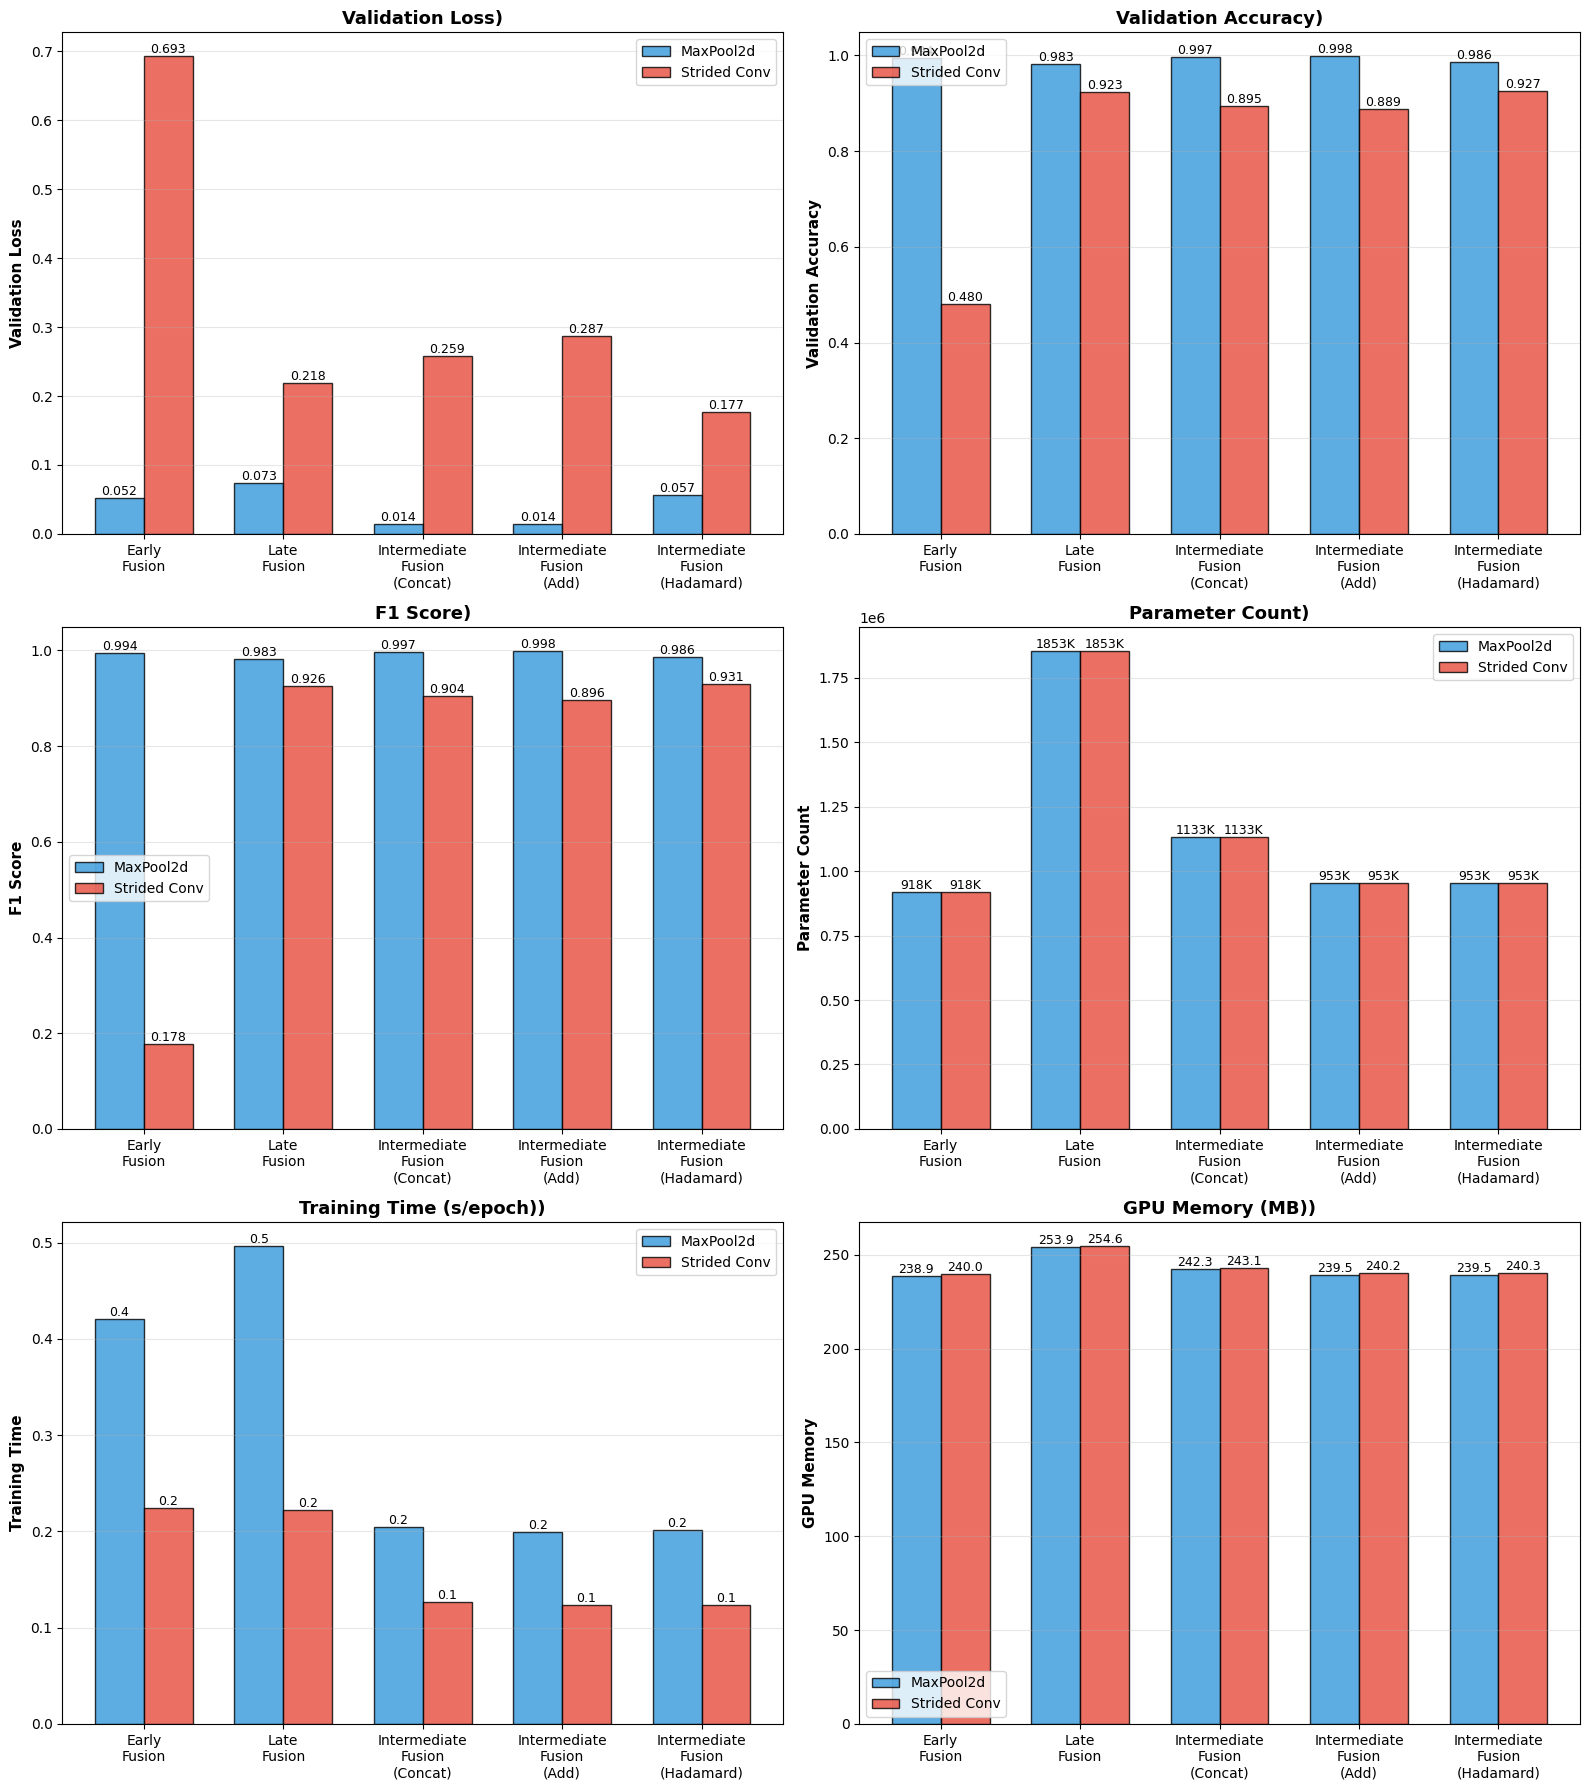


SUMMARY STATISTICS

Average Differences (Strided - MaxPool):
  Validation Loss: +0.2849
  Validation Accuracy: -0.1688
  Parameters: +0
  Time per Epoch: -0.14s


In [6]:
# Visualize ablation results
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Get unique architectures
architectures_list = [r["architecture"] for r in ablation_results[::2]]  # Every other result (MaxPool)

metrics = [
    ("val_loss", "Validation Loss"),
    ("val_accuracy", "Validation Accuracy"),
    ("val_f1", "F1 Score"),
    ("parameters", "Parameter Count"),
    ("time_per_epoch", "Training Time (s/epoch)"),
    ("memory_mb", "GPU Memory (MB)")
]

colors_maxpool = '#3498db'  # Blue
colors_strided = '#e74c3c'  # Red

for idx, (metric_key, title) in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Extract values for MaxPool and Strided
    maxpool_values = [ablation_results[i][metric_key] for i in range(0, len(ablation_results), 2)]
    strided_values = [ablation_results[i][metric_key] for i in range(1, len(ablation_results), 2)]
    
    x = np.arange(len(architectures_list))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, maxpool_values, width, label='MaxPool2d', 
                   color=colors_maxpool, alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, strided_values, width, label='Strided Conv', 
                   color=colors_strided, alpha=0.8, edgecolor='black')
    
    ax.set_title(f"{title})", fontweight='bold', fontsize=13)
    ax.set_ylabel(title.split('(')[0].strip(), fontweight='bold', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels([arch.replace(" ", "\n") for arch in architectures_list], 
                       rotation=0, fontsize=10)
    ax.legend(loc='best', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if metric_key == "parameters":
                label = f"{int(height/1000):.0f}K"
            elif metric_key in ["val_accuracy", "val_f1", "val_loss"]:
                label = f"{height:.3f}"
            else:
                label = f"{height:.1f}"
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('03_strided_conv_ablation_comprehensive_ablation_charts.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

maxpool_wins = 0
strided_wins = 0
ties = 0

for i in range(0, len(ablation_results), 2):
    maxpool_acc = ablation_results[i]['val_accuracy']
    strided_acc = ablation_results[i+1]['val_accuracy']
    
    if strided_acc > maxpool_acc:
        strided_wins += 1
    elif maxpool_acc > strided_acc:
        maxpool_wins += 1
    else:
        ties += 1

# Calculate average differences
avg_loss_diff = np.mean([ablation_results[i+1]['val_loss'] - ablation_results[i]['val_loss'] 
                         for i in range(0, len(ablation_results), 2)])
avg_acc_diff = np.mean([ablation_results[i+1]['val_accuracy'] - ablation_results[i]['val_accuracy'] 
                        for i in range(0, len(ablation_results), 2)])
avg_param_diff = np.mean([ablation_results[i+1]['parameters'] - ablation_results[i]['parameters'] 
                          for i in range(0, len(ablation_results), 2)])
avg_time_diff = np.mean([ablation_results[i+1]['time_per_epoch'] - ablation_results[i]['time_per_epoch'] 
                         for i in range(0, len(ablation_results), 2)])

print(f"\nAverage Differences (Strided - MaxPool):")
print(f"  Validation Loss: {avg_loss_diff:+.4f}")
print(f"  Validation Accuracy: {avg_acc_diff:+.4f}")
print(f"  Parameters: {avg_param_diff:+,.0f}")
print(f"  Time per Epoch: {avg_time_diff:+.2f}s")
print("="*80)


# Analysis of MaxPool2d vs. Strided Convolution 

### Quantitative Comparison of Results
The data clearly shows that MaxPool2d outperforms Strided Convolution across various metrics, including Validation Loss, Validation Accuracy, and F1 Score. For instance, in the Early Fusion architecture, MaxPool2d achieved a validation loss of 0.0516 with a validation accuracy of 99.38% compared to the Strided Conv's validation loss of 0.6931 and an accuracy of 47.97%. This trend continues throughout the other fusion architectures, with F1 scores consistently higher for MaxPool2d, indicating better overall model performance and effectiveness in extracting features.

### Theoretical Differences
MaxPool2d serves to retain essential features by summarizing them within defined regions, effectively reducing dimensionality while preserving spatial hierarchies. In contrast, Strided Convolution introduces a learnable parameter (the filter), influencing how features are detected. This adaptability allows Strided Convolution to potentially learn more complex patterns; however, the observed metrics suggest it may struggle to generalize effectively across the given datasets.

### Impact on Gradient Flow and Learned Features
The two pooling methods significantly affect gradient flow during backpropagation. MaxPool2d simplifies gradients by focusing on high-activation regions, leading to faster convergence and stable training. Strided Convolution, while offering a more intricate feature space, may suffer from vanishing gradients when deeper layers are trained, possibly contributing to the higher loss and lower accuracy.

### Recommendation and Justification
Based on the quantitative results and theoretical analysis, it is recommended to utilize MaxPool2d in preference to Strided Convolution for this dataset. The superior performance metrics across multiple architectures indicate that MaxPool2d not only enhances accuracy and F1 scores but also maintains efficiency in terms of training time and GPU memory. Adopting MaxPool2d maximizes both performance and computational resources, leading to more reliable model outcomes.
